# **Statistical Inference - Otto Group product classification**

Its time to make some inferences from our data. As our final goal is to classify the products into one of the 9 product categories, it would be useful to see if for a given feature the data strongly variates with respect to the target classes.

[Load the cleaned data from previous work (ipynb)](#section1)

[Use ANOVA to see intra-feature class differences](#section2)

[Tukey method for pairwise comparisons](#section3)

[Normalize data](#section4)

[PCA and visualization](#section5)

[LDA and visualization](#section6)

<a id='section1'></a>

### Load cleaned data

In [2]:
# pandas gives high-performance, easy-to-use data structures and data analysis tools
import pandas as pd

# fundamental package for scientific computing
import numpy as np 

# matplotlib provides a MATLAB-like plotting framework
import matplotlib.pyplot as plt
import matplotlib

# seaborn is visualization library based on matplotlib, 
# provides high level interface for drawing attractive statistical graphics
import seaborn as sns
sns.set_style(style='whitegrid')

# for ANOVA
import scipy.stats as stats

# for PCA
from sklearn.decomposition import PCA as sklearnPCA

import time

# for TSNE visualization
from sklearn.manifold import TSNE

In [3]:
# training data set
df = pd.read_csv("../data/train_cleaned.csv")

# test data set
df_test = pd.read_csv("../data/test_cleaned.csv")

In [4]:
df.shape

(61878, 94)

<a id='section2'></a>

### ANOVA to find out intra feature, class differences

ANOVA can determine whether the means of three or more groups are different. It uses F-tests to statistically test the equality of means. However before we jump in doing ANOVA, there are certain assumptions that should satisfy:

1. The different populations should have same variances. This is called assumption of **homogeneity of variance**
2. The different populations should be normally distributed
3. Samples are independent

The first 2 assumptions can be relaxed a bit. We will see next where we stand with respect to the first 2 and what we can do satisfy our assumptions. The 3rd assumption is apparently satisfied because there is no evidence in against of that.

We already know that there is class imbalance. So first let us fix that.

In [5]:
df.target.value_counts()

2    16122
6    14135
8     8464
3     8004
9     4955
7     2839
5     2739
4     2691
1     1929
Name: target, dtype: int64

In [6]:
df_balanced = pd.DataFrame(columns=df.columns)

for i in np.arange(1,10):
    df_balanced = df_balanced.append(df[df.target == i].sample(1929),ignore_index=True)

df_balanced.target.value_counts()

9    1929
8    1929
7    1929
6    1929
5    1929
4    1929
3    1929
2    1929
1    1929
Name: target, dtype: int64

Class imbalances are fixed above by taking equal number of samples from each class. Note that this is done only to do the ANOVA tests.

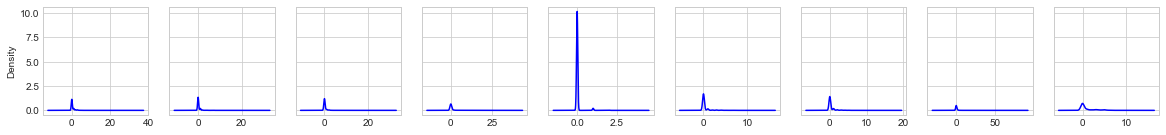

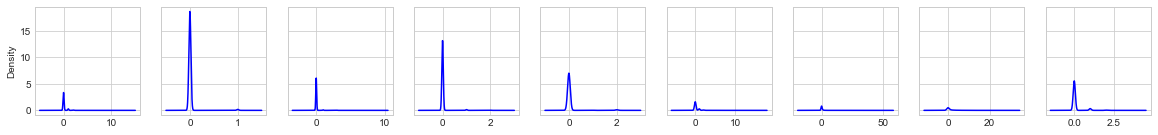

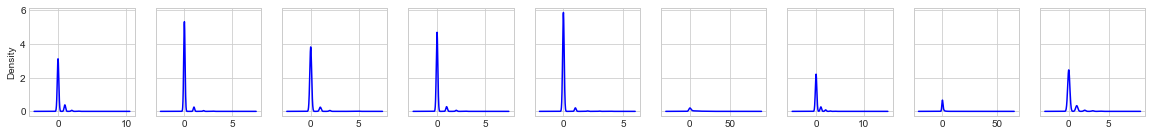

In [7]:
def make_feature_kdeplots(data,feature):
    fig,ax = plt.subplots(ncols=9,nrows=1,sharey=True)

    for i in np.arange(1,10,1): 
        data_sub = data[data.target==i]
        data_sub[feature].plot(ax=ax[i-1],kind="kde",color='blue',figsize=(20,2))   

    plt.show()
    
make_feature_kdeplots(df_balanced,'feat_1')        
make_feature_kdeplots(df_balanced,'feat_2')    
make_feature_kdeplots(df_balanced,'feat_3')    

As can be seen some of the features have more normally distributed populations for different classes, than some other features. So let us do ANOVA and then we can again see variances within top results before deriving conclusions.

In [8]:
# get group data to do ANOVA
groups = df_balanced.groupby("target").groups
features_data = df_balanced.drop("target",axis=1)
classes = [None] * 9
for i in np.arange(0,9):
    classes[i] = features_data.loc[groups[i+1]]

In [9]:
# Perform the ANOVA
(statistic, pvalue) = stats.f_oneway(classes[0], classes[1],classes[2], classes[3],classes[4], classes[5],classes[6], classes[7],classes[8])
anova_df = pd.DataFrame.from_items([('statistic',list(statistic)),('pvalue', list(pvalue)),('feature',np.arange(1,94))])

anova_df.sort_values(by='statistic',ascending=False,inplace=True)

In [10]:
anova_df.head()

,statistic,pvalue,feature
33,4261.245790,0.0,34
10,1252.157339,0.0,11
13,593.276172,0.0,14
24,573.399211,0.0,25
59,569.044453,0.0,60


In [11]:
anova_df.tail()

,statistic,pvalue,feature
92,30.571461,5.488622e-48,93
50,30.122098,3.093491e-47,51
5,29.632265,2.036677e-46,6
62,25.577087,1.195041e-39,63
11,20.609496,2.191640e-31,12


Let us now see top features that have greatest F-statistic values meaning that they have significant differences (p-values=0) in classes. All the classes don't have same variances but can keep in mind these top results for future analysis and modeling.

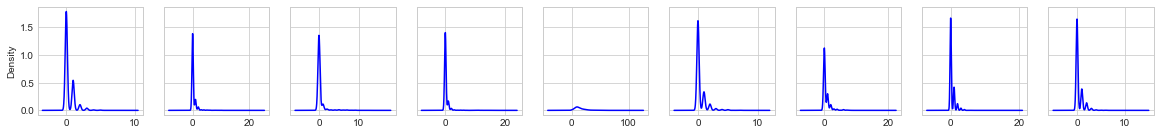

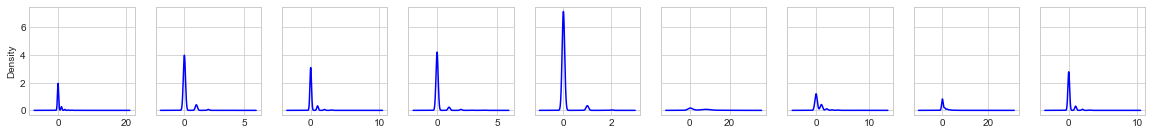

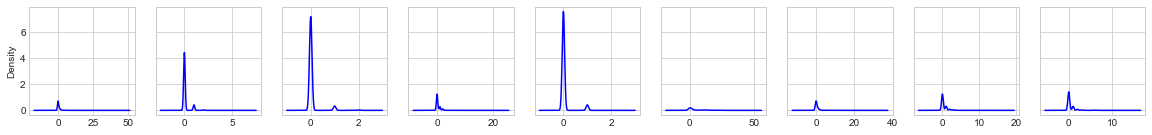

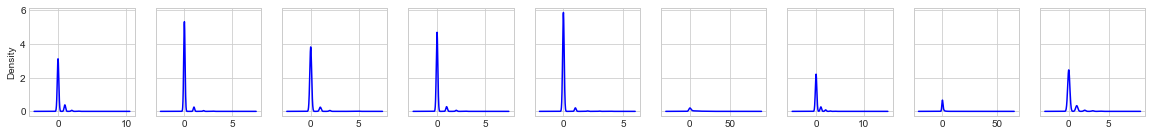

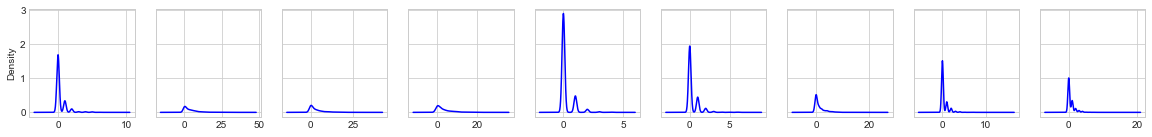

In [12]:
make_feature_kdeplots(df_balanced,'feat_34')        
make_feature_kdeplots(df_balanced,'feat_11')    
make_feature_kdeplots(df_balanced,'feat_60')
make_feature_kdeplots(df_balanced,'feat_3')
make_feature_kdeplots(df_balanced,'feat_14')

<a id='section3'></a>

### Tukey method for pairwise comparisons

Tukey method to pairwise comparisons and also plot means for the 9 classes. The charts show features and means with confidence intervals for the classes.

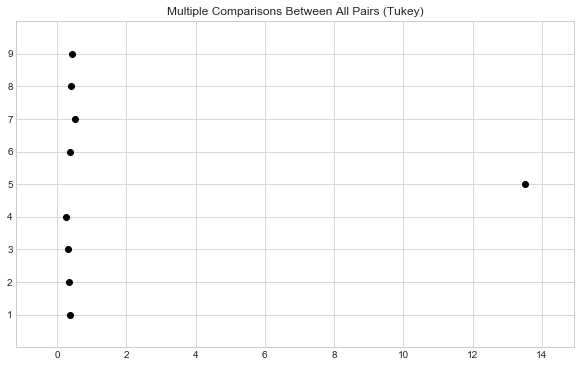

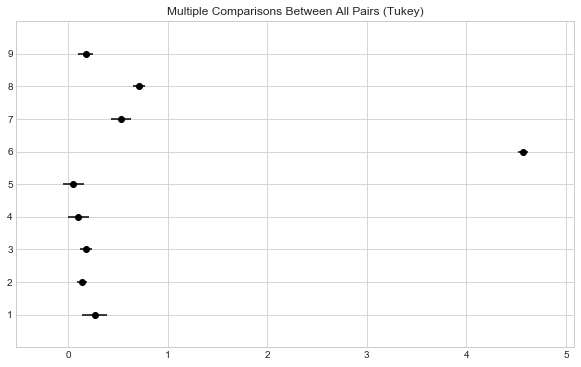

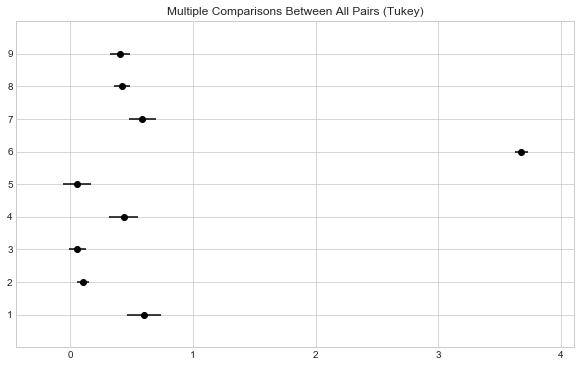

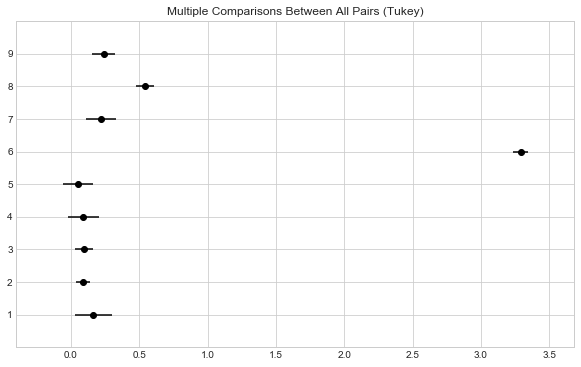

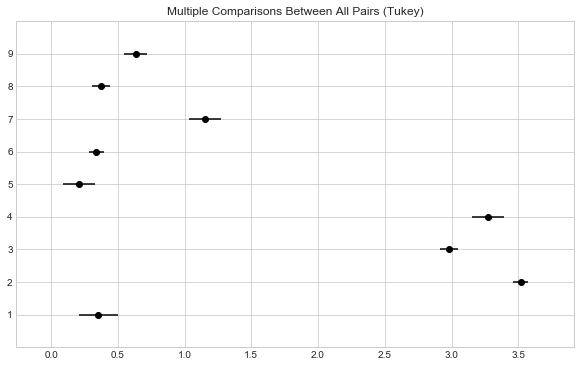

In [13]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def tukey_graph(data, feature):
    tukey = pairwise_tukeyhsd(endog=data[feature],     # Data
                          groups=data.target,   # Groups
                          alpha=0.05)          # Significance level

    tukey.plot_simultaneous()    # Plot group confidence intervals
    #plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")
    #print(tukey.summary())    
    plt.show()
    
# tukey graph for top 5 features from ANOVA
for i in [34,11,60,3,14]:    
    tukey_graph(df, "feat_"+str(i))    

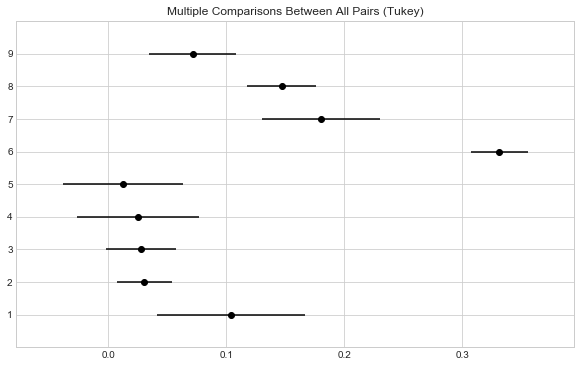

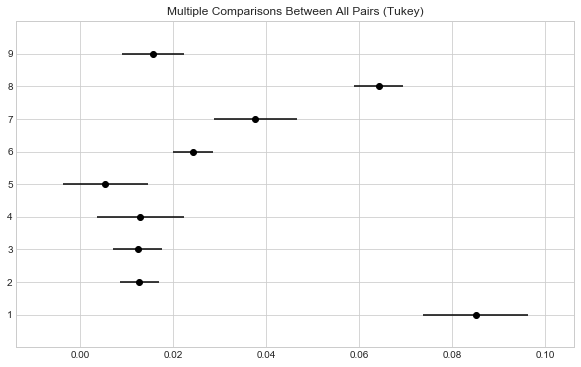

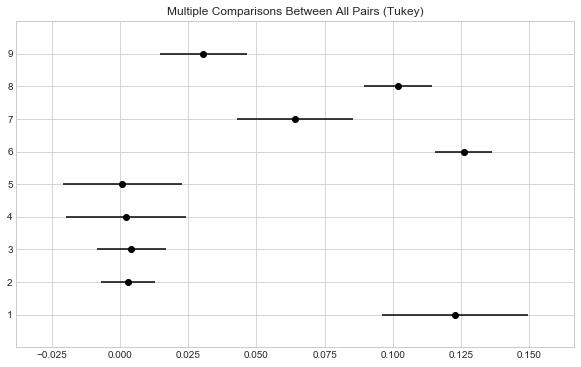

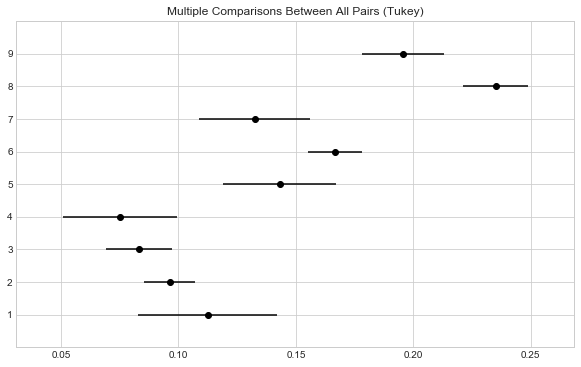

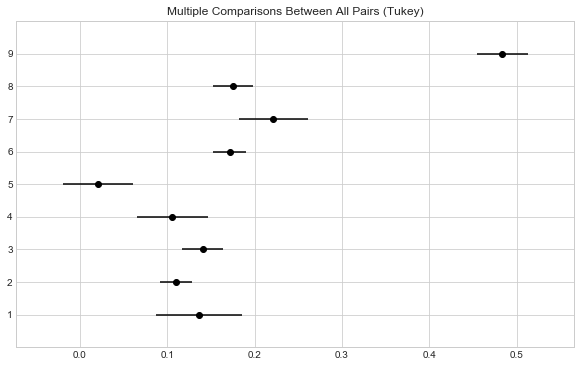

In [15]:
# tukey graph for bottom 5 features from ANOVA
for i in [93,6,51,12,63]:    
    tukey_graph(df,"feat_"+str(i))  

From all the analysis above we infer we following:

1. The feature data is useful and can be used to predict target class. We can say this because there is statiscally significant difference between means for classes.

2. We may have uncovered some reasonable features for our modeling.

<a id='section4'></a>

## Normalizing data

Before further analysis let us normalize our data. It helps if some features are affecting the model just because of the scale of their data as compared to other features.

In [16]:
from sklearn import preprocessing

std_scaler = preprocessing.StandardScaler()
np_scaled = std_scaler.fit_transform(df.drop("target",axis=1))
features_normal = pd.DataFrame(np_scaled)
#features_normal.describe().loc["max"]

In [17]:
train_normal_df = pd.concat([features_normal, pd.DataFrame(df.target)],axis=1)
train_normal_df.columns = df.columns
train_normal_df.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,0.402093,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,-0.293664,-0.291038,-0.243606,...,0.246100,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963,1
1,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,0.149647,-0.291038,-0.243606,...,-0.280099,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963,1
2,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,0.149647,-0.291038,-0.243606,...,-0.280099,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963,1
3,0.402093,-0.210106,-0.307165,0.079240,13.508710,4.524667,4.665884,-0.293664,-0.291038,0.679472,...,-0.280099,-0.047949,1.019683,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963,1
4,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,-0.293664,-0.291038,-0.243606,...,0.246100,-0.420870,-0.249802,-0.413584,-0.299712,0.040798,-0.129516,-0.386938,-0.104963,1


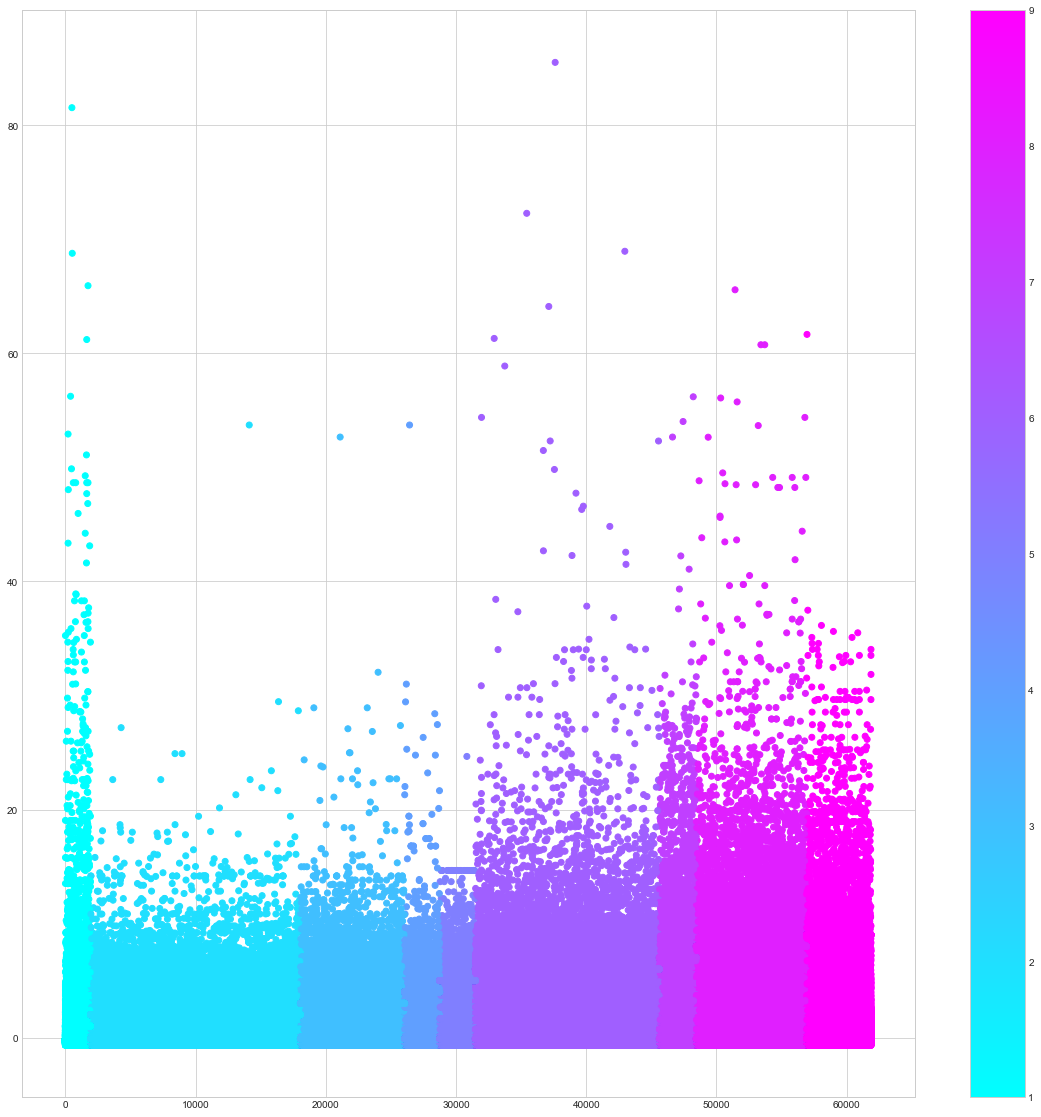

In [27]:
df2 = train_normal_df
plt.figure(figsize=(20,20))
scat = plt.scatter(np.arange(0,len(df2.feat_1)),df2.feat_1,c=df2.target,cmap=plt.cm.cool)
cb = plt.colorbar(scat, spacing='proportional')

for col in df2.columns:
    plt.scatter(np.arange(0,len(df2[col])),df2[col],c=df2.target,cmap=plt.cm.cool)
plt.show()

In [22]:
train_normal_df.to_csv("../data/train_norm.csv",index=False)

<a id='section5'></a>

## PCA on normalized data

In [18]:
sklearn_pca = sklearnPCA()
sklearn_transf = sklearn_pca.fit(features_normal)
sklearn_transf.explained_variance_ratio_

array([ 0.08555694,  0.06587049,  0.04177069,  0.03177853,  0.02821606,
        0.02616521,  0.02389526,  0.02382949,  0.02252596,  0.02065693,
        0.01883292,  0.0185842 ,  0.01849353,  0.01716274,  0.01623459,
        0.01573562,  0.014751  ,  0.01427313,  0.01394629,  0.01314063,
        0.01260882,  0.01232527,  0.01214582,  0.01140202,  0.01112323,
        0.01091383,  0.01048613,  0.01041515,  0.01019281,  0.01012226,
        0.00998693,  0.0099173 ,  0.00964471,  0.00942646,  0.00912104,
        0.00903544,  0.00885692,  0.00873804,  0.0085263 ,  0.00835652,
        0.00823168,  0.00814551,  0.00785824,  0.00771585,  0.00761602,
        0.00749504,  0.00736073,  0.00706931,  0.00704883,  0.00692985,
        0.00678267,  0.00672523,  0.00658681,  0.00652646,  0.00633503,
        0.00622531,  0.00613808,  0.00571476,  0.00562816,  0.00558607,
        0.00554224,  0.00536831,  0.00529224,  0.0052718 ,  0.00522117,
        0.00502023,  0.00489848,  0.00475225,  0.00466247,  0.00

In [19]:
normal_pca_features = sklearn_transf.transform(features_normal)

In [22]:
normal_pca_features
normal_pca_df = pd.DataFrame(normal_pca_features)
normal_pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,-0.322226,0.261640,-0.101271,2.371336,-1.969393,0.606056,-0.519601,0.807828,-0.128615,0.343750,...,-0.626280,0.394135,-0.157771,-0.199786,-0.311419,0.541050,0.069015,-0.184542,-0.046575,0.097835
1,-1.617733,-0.431757,-1.121202,0.293595,-0.614387,0.339935,0.290450,0.032317,-0.690445,0.123639,...,0.135744,0.038507,-0.329023,0.138695,0.000430,-0.054634,-0.050181,0.101434,-0.006674,0.030508
2,-1.529818,-0.013893,-0.474269,0.540099,-0.183968,0.457895,0.391766,0.085182,-0.853228,-0.273631,...,0.158896,0.141192,-0.401972,0.260889,-0.368088,0.430489,0.059703,-0.128953,0.044839,0.122280
3,5.970171,5.383945,-0.781070,7.071108,14.264728,18.608579,18.657943,1.073235,17.123522,12.116826,...,-0.505060,1.302866,-0.870315,0.293537,-6.060343,-8.091420,1.776618,-6.930132,-0.125727,-0.720418
4,-1.215508,0.447809,-0.359539,1.150645,-0.340307,0.464952,0.590288,0.242088,-1.623147,-0.621531,...,0.299125,0.099250,0.053953,-0.119258,0.483242,-0.163679,-0.056049,0.103245,-0.036500,0.234712


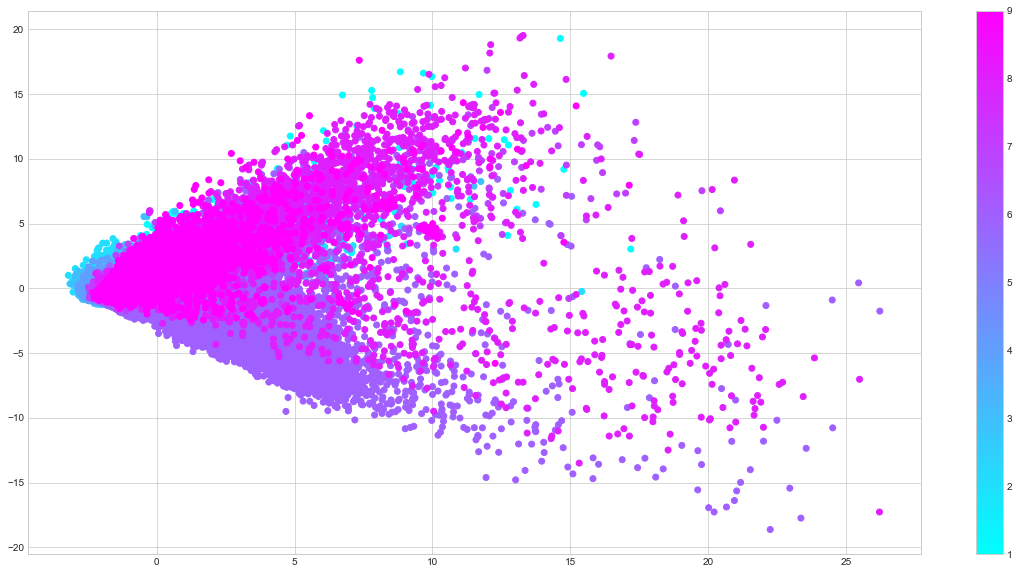

In [32]:
plt.figure(figsize=(20,10))
scat = plt.scatter(x=normal_pca_df.iloc[:,0],y=normal_pca_df.iloc[:,1],c=df.target,cmap=plt.cm.cool)
cb = plt.colorbar(scat, spacing='proportional')
plt.show()

In [23]:
train_pca_df = pd.concat([normal_pca_df, pd.DataFrame(df.target)],axis=1)
cols = [col.replace("feat","pca") for col in df.columns]
train_pca_df.columns = cols
train_pca_df.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,target
0,-0.322226,0.261640,-0.101271,2.371336,-1.969393,0.606056,-0.519601,0.807828,-0.128615,0.343750,...,0.394135,-0.157771,-0.199786,-0.311419,0.541050,0.069015,-0.184542,-0.046575,0.097835,1
1,-1.617733,-0.431757,-1.121202,0.293595,-0.614387,0.339935,0.290450,0.032317,-0.690445,0.123639,...,0.038507,-0.329023,0.138695,0.000430,-0.054634,-0.050181,0.101434,-0.006674,0.030508,1
2,-1.529818,-0.013893,-0.474269,0.540099,-0.183968,0.457895,0.391766,0.085182,-0.853228,-0.273631,...,0.141192,-0.401972,0.260889,-0.368088,0.430489,0.059703,-0.128953,0.044839,0.122280,1
3,5.970171,5.383945,-0.781070,7.071108,14.264728,18.608579,18.657943,1.073235,17.123522,12.116826,...,1.302866,-0.870315,0.293537,-6.060343,-8.091420,1.776618,-6.930132,-0.125727,-0.720418,1
4,-1.215508,0.447809,-0.359539,1.150645,-0.340307,0.464952,0.590288,0.242088,-1.623147,-0.621531,...,0.099250,0.053953,-0.119258,0.483242,-0.163679,-0.056049,0.103245,-0.036500,0.234712,1


In [24]:
train_pca_df.to_csv("../data/train_norm_pca.csv",index=False)

In [25]:
groups = train_pca_df.groupby("target").groups

classes_pca_normal = [None] * 9
for i in np.arange(0,9):
    classes_pca_normal[i] = normal_pca_df.loc[groups[i+1]]


In [26]:
# Perform the ANOVA
(statistic, pvalue) = stats.f_oneway(classes_pca_normal[0], classes_pca_normal[1],classes_pca_normal[2] \
                                     ,classes_pca_normal[3],classes_pca_normal[4], classes_pca_normal[5] \
                                     ,classes_pca_normal[6], classes_pca_normal[7],classes_pca_normal[8])
normal_pca_anova_df = pd.DataFrame.from_items([('statistic',list(statistic)),('pvalue', list(pvalue)),('pca_feature',np.arange(1,94))])

normal_pca_anova_df.sort_values(by='pvalue',inplace=True)

In [27]:
normal_pca_anova_df.head()

,statistic,pvalue,pca_feature
0,3387.540453,0.0,1
33,270.806292,0.0,34
32,209.736158,0.0,33
29,210.366901,0.0,30
28,196.155137,0.0,29


In [28]:
normal_pca_anova_df.tail()

,statistic,pvalue,pca_feature
58,14.038706,1.335089e-20,59
67,12.695296,2.122743e-18,68
62,11.455040,2.224259e-16,63
73,9.897244,7.311580e-14,74
91,1.866049,6.057427e-02,92


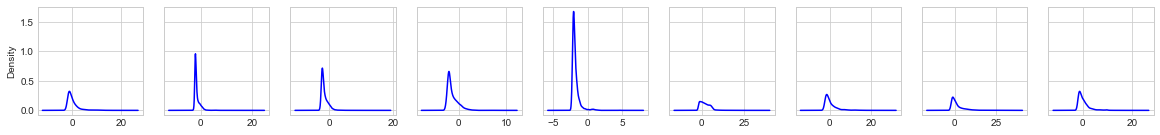

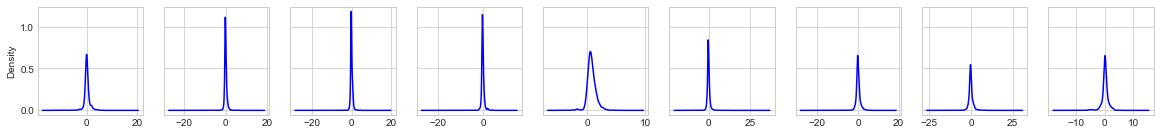

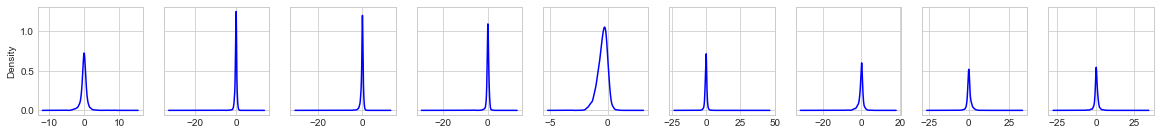

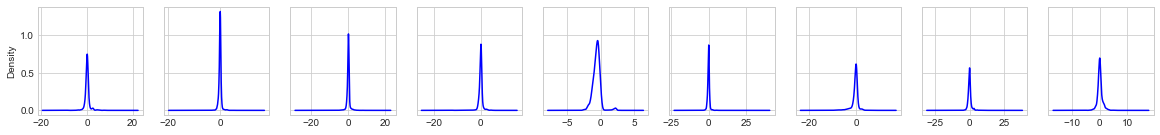

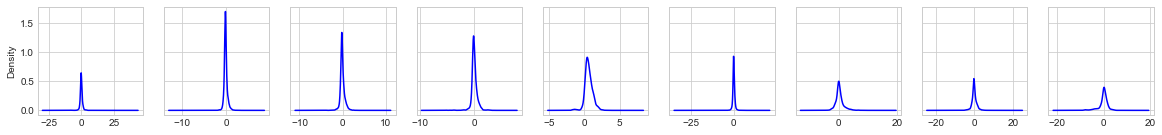

In [29]:
make_feature_kdeplots(train_pca_df,'pca_1')        
make_feature_kdeplots(train_pca_df,'pca_34')    
make_feature_kdeplots(train_pca_df,'pca_33')
make_feature_kdeplots(train_pca_df,'pca_30')
make_feature_kdeplots(train_pca_df,'pca_29')

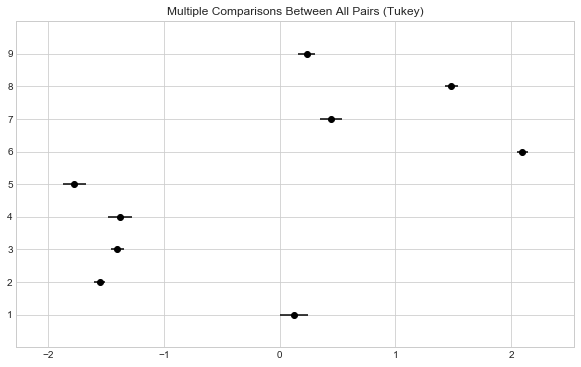

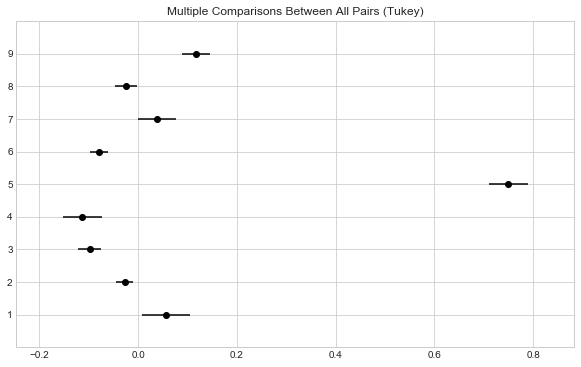

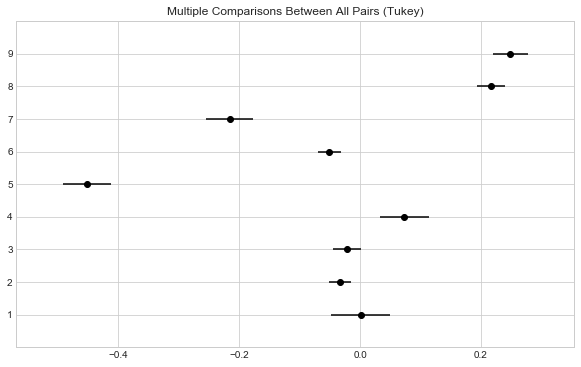

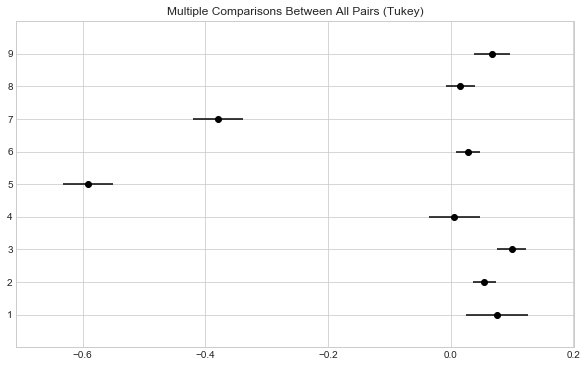

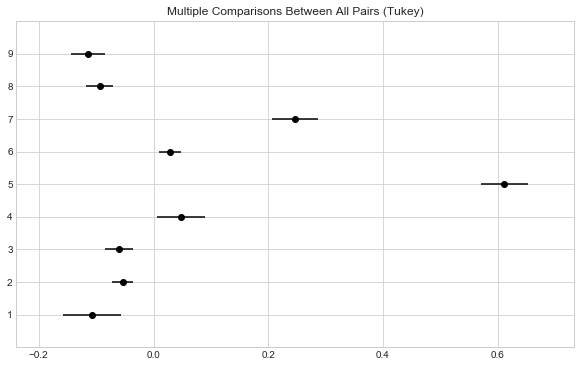

In [30]:
# tukey graph for top 5 features from ANOVA
for i in [1,34,33,30,29]:    
    tukey_graph(train_pca_df, "pca_"+str(i))  

In [65]:
import time

from sklearn.manifold import TSNE

n_sne = 8000

# take n_sne sample from all records and save the indexes
sample_idxs = normal_pca_df.sample(n=n_sne).index
#df.iloc[sample_idxs]

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(normal_pca_df.iloc[sample_idxs])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.022s...
[t-SNE] Computed neighbors for 8000 samples in 8.671s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 1.349595
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.007126
[t-SNE] Error after 300 iterations: 2.327178


In [63]:
#pd.DataFrame(tsne_results).to_csv("../data/tsne_2comp_full.csv")

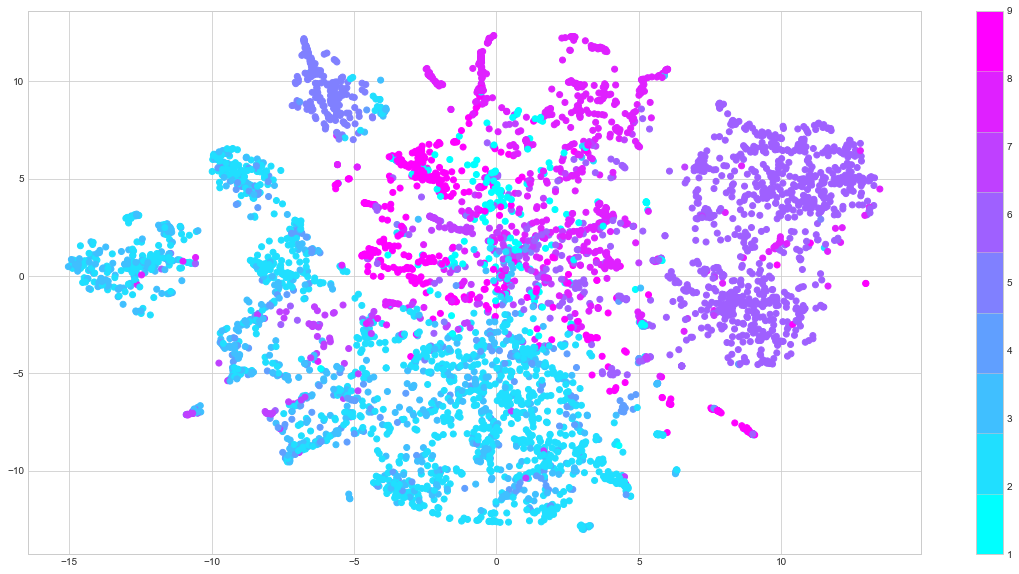

In [64]:
plt.figure(figsize=(20,10))
cmap = plt.get_cmap('cool', 9)
scat = plt.scatter(x=tsne_results[:,0],y=tsne_results[:,1],c=df.target.iloc[sample_idxs],cmap=cmap)
cb = plt.colorbar(scat, spacing='uniform',drawedges=True)

plt.show()

<a id='section6'></a>

### LDA visualization

Try out LDA for feature reduction

In [31]:
features_normal.head()

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,0.402093,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,-0.293664,-0.291038,-0.243606,...,-0.061446,0.246100,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963
1,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,0.149647,-0.291038,-0.243606,...,-0.061446,-0.280099,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963
2,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,0.149647,-0.291038,-0.243606,...,-0.061446,-0.280099,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963
3,0.402093,-0.210106,-0.307165,0.079240,13.508710,4.524667,4.665884,-0.293664,-0.291038,0.679472,...,19.044887,-0.280099,-0.047949,1.019683,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963
4,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,-0.293664,-0.291038,-0.243606,...,-0.061446,0.246100,-0.420870,-0.249802,-0.413584,-0.299712,0.040798,-0.129516,-0.386938,-0.104963


In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda_fit = lda.fit(features_normal, df.target)
print(lda_fit.explained_variance_ratio_)
#print("score: ",lda_fit.score(features_normal, df.target))

lda_features = lda_fit.transform(features_normal)
print(lda_features[0:5])

[ 0.35357105  0.24095919  0.19456321  0.12883597  0.05275278  0.01427669
  0.00914221  0.0058989 ]
[[ -3.61359414e+00   7.27558538e-03   1.45317310e+00   9.80170003e-02
    2.03524296e-01  -6.09068839e-01  -3.82075178e-01   7.87442305e-02]
 [  6.44804120e-02  -8.49021453e-02  -6.09263119e-01  -1.58185165e-01
   -5.62154878e-02  -7.48498803e-01  -5.34842822e-02   9.46970053e-03]
 [  1.10224173e-01  -1.14146007e-01  -5.05296365e-01   2.91738205e-01
   -3.92444633e-01  -1.80101242e+00  -5.78583655e-02   4.42887773e-02]
 [  2.80555570e-01  -4.85567075e-01  -3.42754145e+00   2.15649546e+00
    1.52518103e+00  -1.36842495e+01  -4.11220687e+00   3.87326138e+00]
 [ -7.67037598e-02  -1.98314958e-01  -1.25686346e+00   3.67735919e-01
   -1.06517814e+00  -1.61152921e+00  -1.04006843e+00   4.36537471e-01]]


<font color='red'>not sure why only 8 features produced by lda above</font>

In [33]:
%matplotlib inline

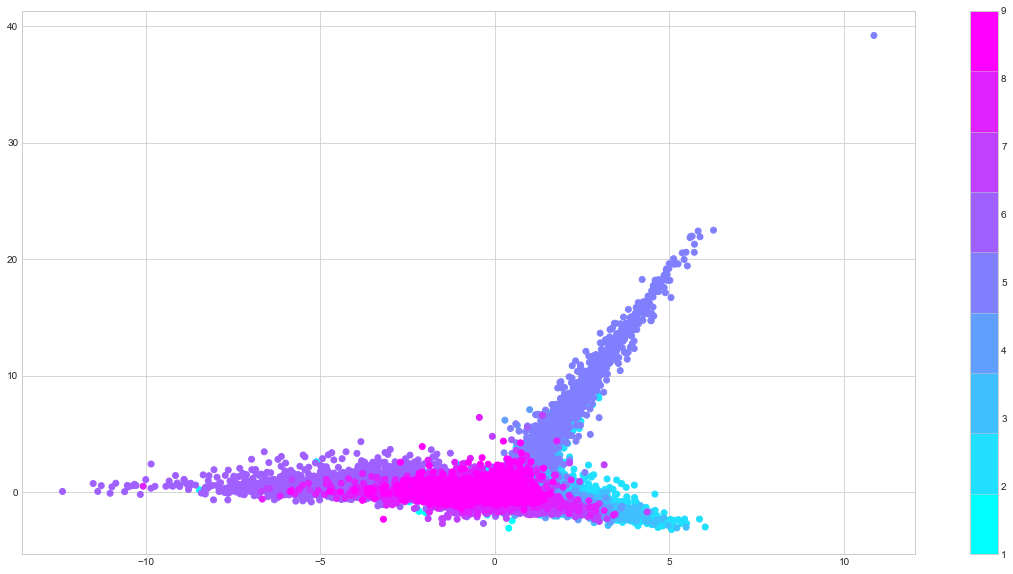

In [34]:
plt.figure(figsize=(20,10))
cmap = plt.get_cmap('cool', 9)
scat = plt.scatter(x=lda_features[:,0],y=lda_features[:,1],c=df.target,cmap=cmap)
cb = plt.colorbar(scat, spacing='uniform',drawedges=True)

plt.show()

Can see that LDA has separated the data with respect to different classes.